<a href="https://colab.research.google.com/github/Hushpuppyzac/DLI-Assignment/blob/main/eric_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import nbformat
from IPython import get_ipython

def run_notebook_from_github(url):
    print("🔄 Downloading notebook from GitHub...")
    try:
        response = requests.get(url)
        response.raise_for_status()
    except Exception as e:
        print(f"❌ Failed to download notebook: {e}")
        return

    print("📖 Parsing notebook content...")
    try:
        notebook = nbformat.reads(response.text, as_version=4)
    except Exception as e:
        print(f"❌ Failed to parse notebook: {e}")
        return

    ipython = get_ipython()
    if ipython is None:
        print("❌ This function must be run in a Jupyter environment.")
        return

    print("⚙️ Running notebook cells...\n")
    for i, cell in enumerate(notebook.cells):
        if cell.cell_type == 'code':
            try:
                print(f"▶️ Executing cell [{i + 1}]...")
                ipython.run_cell(cell.source)
            except Exception as e:
                print(f"❌ Error in cell [{i + 1}]: {e}")

    print("\n✅ All executable cells have been processed.")

notebook_url = "https://raw.githubusercontent.com/Hushpuppyzac/DLI-Assignment/main/CleanedData.ipynb"
run_notebook_from_github(notebook_url)

🔄 Downloading notebook from GitHub...
📖 Parsing notebook content...
⚙️ Running notebook cells...

▶️ Executing cell [2]...

             INITIAL DATASET INFORMATION             
Total rows before any cleaning: 225,745
Initial Label distribution (raw data):


,count
Label,
DDoS,128027
BENIGN,97718



--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             225745 non-null  int64  
 1    Flow Duration                225745 non-null  int64  
 2    Total Fwd Packets            225745 non-null  int64  
 3    Total Backward Packets       225745 non-null  int64  
 4   Total Length of Fwd Packets   225745 non-null  int64  
 5    Total Length of Bwd Packets  225745 non-null  int64  
 6    Fwd Packet Length Max        225745 non-null  int64  
 7    Fwd Packet Length Min        225745 non-null  int64  
 8    Fwd Packet Length Mean       225745 non-null  float64
 9    Fwd Packet Length Std        225745 non-null  float64
 10  Bwd Packet Length Max         225745 non-null  int64  
 11   Bwd Packet Length Min        225745 non-null  int64  
 12   Bwd Packet Length M

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,225745.00000,2.257450e+05,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,...,225745.000000,225745.000000,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05
mean,8879.61946,1.624165e+07,4.874916,4.572775,939.463346,5.960477e+03,538.535693,27.882221,164.826715,214.907242,...,3.311497,21.482753,1.848261e+05,1.293436e+04,2.080849e+05,1.776201e+05,1.032214e+07,3.611943e+06,1.287813e+07,7.755355e+06
std,19754.64740,3.152437e+07,15.422874,21.755356,3249.403484,3.921834e+04,1864.128991,163.324159,504.892965,797.411073,...,12.270018,4.166799,7.979250e+05,2.102737e+05,9.002350e+05,7.842602e+05,2.185303e+07,1.275689e+07,2.692126e+07,1.983109e+07
min,0.00000,-1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,80.00000,7.118000e+04,2.000000,1.000000,26.000000,0.000000e+00,6.000000,0.000000,6.000000,0.000000,...,1.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,80.00000,1.452333e+06,3.000000,4.000000,30.000000,1.640000e+02,20.000000,0.000000,8.666667,5.301991,...,2.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,80.00000,8.805237e+06,5.000000,5.000000,63.000000,1.160100e+04,34.000000,6.000000,32.000000,10.263203,...,4.000000,20.000000,1.878000e+03,0.000000e+00,1.878000e+03,1.862000e+03,8.239725e+06,0.000000e+00,8.253838e+06,7.422849e+06
max,65532.00000,1.199999e+08,1932.000000,2942.000000,183012.000000,5.172346e+06,11680.000000,1472.000000,3867.000000,6692.644993,...,1931.000000,52.000000,1.000000e+08,3.950000e+07,1.000000e+08,1.000000e+08,1.200000e+08,6.530000e+07,1.200000e+08,1.200000e+08




--- DataFrame Columns after stripping whitespace and renaming ---
['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', '

,count
Label,
1,128014
0,95068



First 5 rows of cleaned DataFrame:


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0




             AFTER INITIAL TRAIN-TEST SPLIT             
Training data shape (X_train): (178465, 68)
Testing data shape (X_test):   (44617, 68)
Training label shape (y_train): (178465,)
Testing label shape (y_test):   (44617,)

Training label distribution:


,count
Label,
1,102411
0,76054



Testing label distribution:


,count
Label,
1,25603
0,19014




--- Class Distribution Before Balancing (Training Set) ---


,count
Label,
1,102411
0,76054



         AFTER UNDERSAMPLING (Training Set Only)         
Total rows in balanced training set: 152,108
Class balance (Training Set):


,count
Label,
0,76054
1,76054




        SAMPLE OF BALANCED TRAINING DATAFRAME        
Total Rows       : 152,108
DDoS Attacks     : 76,054
Benign Records   : 76,054

Balanced Training DataFrame (First 5 Rows):


,Destination Port,Flow Duration,Label
0,53,108497,0
1,61761,48116,0
2,59618,65,0
3,55903,9318481,0
4,80,9402695,1



DDoS Samples (Balanced Training Set - First 5):


,Destination Port,Flow Duration,Label
4,80,9402695,1
6,80,7373820,1
8,80,2857734,1
9,80,10943778,1
13,80,1784554,1



Benign Samples (Balanced Training Set - First 5):


,Destination Port,Flow Duration,Label
0,53,108497,0
1,61761,48116,0
2,59618,65,0
3,55903,9318481,0
5,80,5860218,0




        AFTER FEATURE EXTRACTION (TRAIN & TEST)        

Sample Extracted Features (Training Set - First 5):


,pkt_length_diff,pkt_length_var_ratio,byte_ratio,duration_per_packet,avg_to_max_ratio
0,62,1.611,0.431,54248.229,0.931
1,11595,7.974,446.423,6873.704,0.143
2,0,0.000,0.000,32.500,0.000
3,0,1.000,0.200,1553077.578,1.167
4,0,1.000,3000000.000,1880535.239,1.200



Final Columns (Training Set after Feature Extraction):
['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'ECE Flag Count', 'Down/Up R

,pkt_length_diff,pkt_length_var_ratio,byte_ratio,duration_per_packet,avg_to_max_ratio
139654,0,1.000,0.200,819400.634,1.167
127815,5840,4.521,0.002,93517.633,0.249
111648,0,1.000,0.167,130544.814,1.143
76785,5840,4.521,0.002,7943.865,0.249
72328,0,1.000,3000000.000,61111.478,1.200



Final Columns (Testing Set after Feature Extraction):
['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'ECE Flag Count', 'Down/Up Ra

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,pkt_length_diff,pkt_length_var_ratio,byte_ratio,duration_per_packet,avg_to_max_ratio
0,-0.496462,-0.511479,-0.245222,-0.168530,-0.303820,-0.138477,-0.292419,0.082431,-0.269685,-0.294430,...,-0.220676,-0.469879,-0.279191,-0.475267,-0.390354,-0.788134,-0.663447,-0.042185,-0.558311,0.632065
1,2.424285,-0.513378,0.004044,-0.123929,3.008621,-0.140547,5.431752,-0.182254,3.902286,5.708969,...,-0.220676,-0.469879,-0.279191,-0.475267,-0.390354,2.285842,1.203662,-0.042170,-0.578708,-0.982426
2,2.322853,-0.514890,-0.245222,-0.168530,-0.317288,-0.141196,-0.315716,-0.182254,-0.355898,-0.294430,...,-0.220676,-0.469879,-0.279191,-0.475267,-0.390354,-0.804659,-1.136167,-0.042185,-0.581654,-1.275411
3,2.147016,-0.221781,-0.245222,0.009873,-0.315569,-0.140448,-0.312742,-0.148465,-0.344892,-0.294430,...,-0.204030,-0.041240,-0.279191,-0.126852,0.081679,-0.804659,-0.842734,-0.042185,0.087018,1.115593
4,-0.495185,-0.219132,0.004044,-0.213131,-0.308692,-0.141196,-0.312742,-0.148465,-0.344892,-0.294430,...,-0.217260,-0.036873,-0.279191,-0.123302,0.086489,-0.804659,-0.842734,0.058275,0.228007,1.183205



Sample of Scaled Testing Data (First 5 Rows):


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,pkt_length_diff,pkt_length_var_ratio,byte_ratio,duration_per_packet,avg_to_max_ratio
139654,2.095897,-0.360247,-0.245222,0.009873,-0.315569,-0.140448,-0.312742,-0.148465,-0.344892,-0.294430,...,-0.220676,-0.469879,-0.279191,-0.475267,-0.390354,-0.804659,-0.842734,-0.042185,-0.228870,1.115593
127815,-0.495185,-0.491359,-0.120589,0.009873,-0.309838,0.148192,-0.305803,-0.182254,-0.340001,-0.282545,...,-0.220676,-0.469879,-0.279191,-0.475267,-0.390354,0.751919,0.190441,-0.042185,-0.541403,-0.765248
111648,2.589378,-0.486148,-0.245222,0.054474,-0.315569,-0.140298,-0.312742,-0.148465,-0.344892,-0.294430,...,-0.220676,-0.469879,-0.279191,-0.475267,-0.390354,-0.804659,-0.842734,-0.042185,-0.525461,1.066421
76785,-0.495185,-0.512893,-0.120589,0.009873,-0.309838,0.148192,-0.305803,-0.182254,-0.340001,-0.282545,...,-0.220676,-0.469879,-0.279191,-0.475267,-0.390354,0.751919,0.190441,-0.042185,-0.578247,-0.765248
72328,-0.495185,-0.505281,0.004044,-0.213131,-0.308692,-0.141196,-0.312742,-0.148465,-0.344892,-0.294430,...,-0.220676,-0.469879,-0.279191,-0.475267,-0.390354,-0.804659,-0.842734,0.058275,-0.555356,1.183205




✅ All executable cells have been processed.


Algorithm : SVM
Confusion Matrix Heatmap

In [2]:
try:
    print("X_train_scaled shape:", X_train_scaled.shape)
    print("y_train_balanced shape:", y_train_balanced.shape)
    print("X_test_scaled shape:", X_test_scaled.shape)
    print("y_test shape:", y_test.shape)
except NameError as e:
    print(f"Error: {e}. Please ensure the preprocessing step from 'cleaned_data_corrected' has been executed.")

X_train_scaled shape: (152108, 73)
y_train_balanced shape: (152108,)
X_test_scaled shape: (44617, 73)
y_test shape: (44617,)



🎯 SVM Model Results:
Accuracy : 0.9990
Precision: 0.9991
Recall   : 0.9991
F1 Score : 0.9991
ROC AUC  : 0.9999


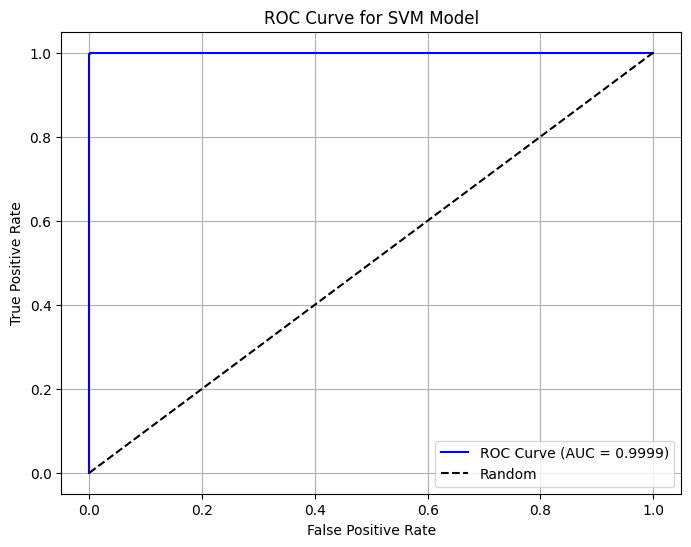

In [3]:
import numpy as np
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Check if required variables exist
try:
    if not all(var in globals() for var in ['X_train_scaled', 'y_train_balanced', 'X_test_scaled', 'y_test']):
        raise NameError("One or more required variables (X_train_scaled, y_train_balanced, X_test_scaled, y_test) are not defined.")
except NameError as e:
    print(f"Error: {e}. Please run the 'CleanedData.ipynb' notebook first.")
    exit()

# Convert labels to integers
y_train_balanced = y_train_balanced.astype(int)
y_test = y_test.astype(int)

# Train Calibrated SVM
try:
    svm_base = SVC(kernel='rbf', probability=True, random_state=42)
    svm_clf = CalibratedClassifierCV(svm_base, cv=3)
    svm_clf.fit(X_train_scaled, y_train_balanced)
except Exception as e:
    print(f"Error training SVM: {e}")
    exit()

# Predict and evaluate
try:
    y_pred = svm_clf.predict(X_test_scaled)
    y_proba = svm_clf.predict_proba(X_test_scaled)[:, 1]
except NameError as e:
    print(f"Error: {e}. Ensure X_test_scaled is defined.")
    exit()

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='binary')
rec = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
roc = roc_auc_score(y_test, y_proba)

print("\n🎯 SVM Model Results:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()